# 04 – One‐Layer Neural Network on TF–IDF Features

In this notebook we will:
1. Load SP train/val/test splits and clean the text.  
2. Load our saved TF–IDF vectorizer and transform all splits.  
3. Build an efficient PyTorch `Dataset`/`DataLoader` that converts one sample at a time.  
4. Define a one-layer MLP (20 000→512→2) with ReLU + Dropout.  
5. Train with Adam, using early stopping on validation F1.  
6. Plot training/validation loss & F1 curves.  
7. Evaluate on the test set (classification report + confusion matrix).  
8. Save the best and final model parameters.


In [1]:
!pip install --quiet pandas numpy scipy scikit-learn nltk torch matplotlib joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.2 MB/s eta 0:00:00


In [2]:
# 1) Standard imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
plt.style.use('ggplot')


In [3]:
# 2) Notebook parameters
TASK         = "sp"  # change to "hh" or "bd" if desired
MAX_FEATURES = 20000
HIDDEN_DIM   = 512
DROPOUT      = 0.5
LR           = 1e-3
BATCH_SIZE   = 256
EPOCHS       = 10
PATIENCE     = 2      # how many epochs to wait before early stop
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on:", DEVICE)


Running on: cuda


In [4]:
# 3) Load splits and clean text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

STOP = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    txt = text.lower()
    txt = re.sub(r'<[^>]+>', ' ', txt)               # remove HTML
    txt = re.sub(r'http\S+|www\.\S+', ' ', txt)      # remove URLs
    txt = re.sub(r'[^a-z\s]', ' ', txt)              # keep letters + space
    txt = re.sub(r'\s+', ' ', txt).strip()           # collapse whitespace
    tokens = [w for w in txt.split() if w not in STOP]
    return ' '.join(lemmatizer.lemmatize(w) for w in tokens)

# load CSVs
train_df = pd.read_csv(f"./project_splits/{TASK}_train.csv")
val_df   = pd.read_csv(f"./project_splits/{TASK}_val.csv")
test_df  = pd.read_csv(f"./project_splits/{TASK}_test.csv")

# apply cleaning
for df in (train_df, val_df, test_df):
    df['cleaned'] = df['Text'].apply(clean_text)

# extract labels
y_train = train_df['label'].values
y_val   = val_df['label'].values
y_test  = test_df['label'].values

print("Sizes ➔", len(train_df), "train,", len(val_df), "val,", len(test_df), "test")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sizes ➔ 368069 train, 52581 val, 105164 test


In [5]:
# 4) Load the saved TF–IDF vectorizer & transform splits
tfidf = joblib.load(f"models/{TASK}_tfidf_vectorizer.joblib")

X_train = tfidf.transform(train_df['cleaned'])
X_val   = tfidf.transform(val_df['cleaned'])
X_test  = tfidf.transform(test_df['cleaned'])

print("TF–IDF shapes:", X_train.shape, X_val.shape, X_test.shape)


TF–IDF shapes: (368069, 20000) (52581, 20000) (105164, 20000)


In [6]:
# 5) Efficient Dataset/DataLoader for sparse TF–IDF

class SparseReviewDataset(Dataset):
    def __init__(self, X_sparse, y_array):
        self.X = X_sparse  # scipy CSR matrix
        self.y = y_array   # numpy array

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # convert a single row to dense
        row = self.X[idx].toarray().ravel()           # shape (MAX_FEATURES,)
        xi  = torch.from_numpy(row).float().to(DEVICE)
        yi  = torch.tensor(self.y[idx], dtype=torch.long).to(DEVICE)
        return xi, yi

# instantiate and wrap in DataLoader
train_ds = SparseReviewDataset(X_train, y_train)
val_ds   = SparseReviewDataset(X_val,   y_val)
test_ds  = SparseReviewDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

print("Batches ➔", len(train_loader), "train,", len(val_loader), "val")


Batches ➔ 1438 train, 206 val


In [7]:
# 6) Define the one-layer MLP
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x):
        return self.net(x)

model     = MLP(MAX_FEATURES, HIDDEN_DIM, DROPOUT).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(model)


MLP(
  (net): Sequential(
    (0): Linear(in_features=20000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [8]:
# 7) Training loop with early stopping on val F1
best_val_f1 = 0.0
no_improve   = 0
history      = {'train_loss':[], 'val_loss':[], 'val_f1':[]}

for epoch in range(1, EPOCHS+1):
    # — Training —
    model.train()
    running_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)

    # — Validation —
    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            out = model(Xb)
            val_loss += criterion(out, yb).item() * Xb.size(0)
            all_preds.extend(out.argmax(dim=1).cpu().tolist())
            all_targets.extend(yb.cpu().tolist())
    val_loss /= len(val_loader.dataset)
    val_f1   = f1_score(all_targets, all_preds, average='binary')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_f1={val_f1:.4f}")

    # early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve   = 0
        torch.save(model.state_dict(), f"models/{TASK}_nn_best.pth")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping after", epoch, "epochs.")
            break


Epoch 1: train_loss=0.1777, val_loss=0.1389, val_f1=0.9687
Epoch 2: train_loss=0.1129, val_loss=0.1278, val_f1=0.9719
Epoch 3: train_loss=0.0812, val_loss=0.1259, val_f1=0.9736
Epoch 4: train_loss=0.0523, val_loss=0.1296, val_f1=0.9745
Epoch 5: train_loss=0.0310, val_loss=0.1384, val_f1=0.9744
Epoch 6: train_loss=0.0174, val_loss=0.1545, val_f1=0.9741
Early stopping after 6 epochs.


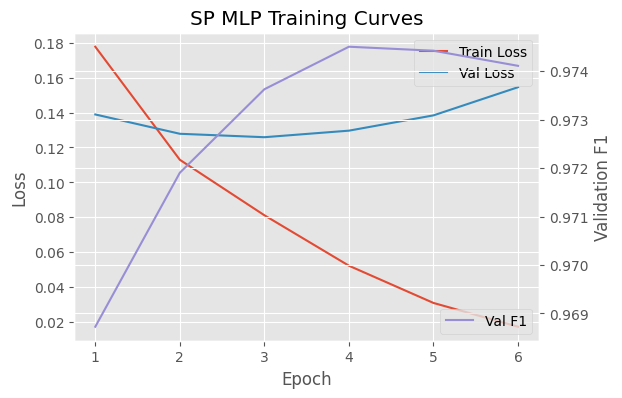

In [9]:
# 8) Plot the training & validation curves
epochs = list(range(1, len(history['train_loss'])+1))
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(epochs, history['train_loss'], label='Train Loss')
ax1.plot(epochs, history['val_loss'],   label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(epochs, history['val_f1'], color='C2', label='Val F1')
ax2.set_ylabel('Validation F1')
ax2.legend(loc='lower right')

plt.title(f"{TASK.upper()} MLP Training Curves")
plt.show()


Test Classification Report:

              precision    recall  f1-score   support

           0      0.892     0.825     0.857     16407
           1      0.968     0.982     0.975     88757

    accuracy                          0.957    105164
   macro avg      0.930     0.903     0.916    105164
weighted avg      0.956     0.957     0.956    105164



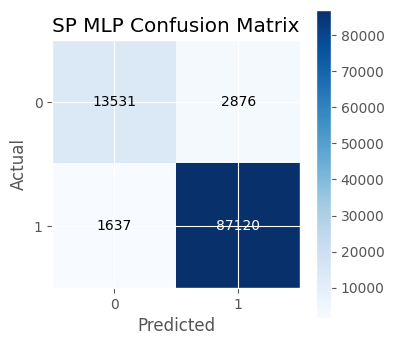

In [10]:
# 9) Load best model & evaluate on TEST
model.load_state_dict(torch.load(f"models/{TASK}_nn_best.pth"))
model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        out = model(Xb)
        all_preds.extend(out.argmax(dim=1).cpu().tolist())
        all_targets.extend(yb.cpu().tolist())

print("Test Classification Report:\n")
print(classification_report(all_targets, all_preds, digits=3))

cm = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap='Blues')
plt.colorbar(im, ax=ax)
ax.set_xticks([0,1]); ax.set_xticklabels(['0','1'])
ax.set_yticks([0,1]); ax.set_yticklabels(['0','1'])
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
for i in (0,1):
    for j in (0,1):
        ax.text(j, i, cm[i,j], ha='center', va='center',
                color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.title(f"{TASK.upper()} MLP Confusion Matrix")
plt.show()


In [12]:
# 10) Save the final model parameters
torch.save(model.state_dict(), f"models/{TASK}_nn_final.pth")
print("Saved final one‐layer NN model to models/{TASK}_nn_final.pth")


Saved final one‐layer NN model to models/{TASK}_nn_final.pth
